# Feed Forward Neural Networks - Binary classification problem
## by Vesna Pop-Dimitrijoska
---

Dataset:     
1. `heart-data.csv`      

Task:
1. EDA (single и bivariate)     
2. NAN values imputation     
3. Binary classification with Feed Forward Neural Networks for predicting target class 'stroke'

---
# Loading the libraries

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm       
import copy
import os
import pathlib
from collections import Counter

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler                   
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

import warnings
warnings.filterwarnings('ignore')

---
# Read the Dataset

In [2]:
org_df = pd.read_csv('heart-data.csv', index_col=0).reset_index(drop=True) 
df = org_df.copy()

display(df.head())

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


---
# Preliminary analysis of a dataset

In [3]:
print('Shape of the dataset:\n-------------------------------------------------------------')
print(f'{df.shape[0]} x {df.shape[1]}\n\n')

print('Basic info of the dataset:\n-------------------------------------------------------------')
print(df.info(), '\n\n')

print('Sum of NaN values in each column:\n-------------------------------------------------------------')
print(df.isna().sum(), '\n\n')

Shape of the dataset:
-------------------------------------------------------------
5110 x 11


Basic info of the dataset:
-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB
None 


Sum of NaN v

In [4]:
print('Duplicates in the dataset:\n-------------------------------------------------------------')
display(df.loc[df.duplicated()])

print('\n\n\nUnique data in the dataset:\n-------------------------------------------------------------')
print(df.nunique().sort_values())

Duplicates in the dataset:
-------------------------------------------------------------


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke





Unique data in the dataset:
-------------------------------------------------------------
hypertension            2
heart_disease           2
ever_married            2
Residence_type          2
stroke                  2
gender                  3
smoking_status          4
work_type               5
age                   104
bmi                   418
avg_glucose_level    3979
dtype: int64


In [5]:
# Summary Statistics of the dataset

df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
# Analysis of unique categories in categorical data

categorical_columns = df.select_dtypes('object').columns
numerical_columns = df.select_dtypes('number').columns

for column in categorical_columns:
    print(f'{column}:\n', df[column].unique(), '\n')

gender:
 ['Male' 'Female' 'Other'] 

ever_married:
 ['Yes' 'No'] 

work_type:
 ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked'] 

Residence_type:
 ['Urban' 'Rural'] 

smoking_status:
 ['formerly smoked' 'never smoked' 'smokes' 'Unknown'] 



In [7]:
# Data types

df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

---
# Preliminary analysis of a dataset:
---
### Shape of a Dataset:     
Shape of the dataset is: 5110 rows x 11 columns (without index column).

### NaN values:  
There are 201 rows with NaN values in 'bmi' feature that should be imputed. I think that preferred method will be to impute them with Linear Regression. 

### Constant values:  
There are no constant value columns.  

### Non-informative and semantic irrelevant features
There are not such columns in the dataset. 

### Data types:  
Data types are correct but they should be converted in more efficient data types with smaller precision.  

### Duplicates:  
There are no duplicate rows in the dataset.

### Typos:       
There are no typos that need to be corrected.

### Descriptive statistics:
The summary statistics is showing that data are on a similar scale. 

#

---
# Exploratory Data Analysis

## Target class analysis - Univariate analysis

Distribution of the target class:
-------------------------------------
0    4861
1     249
Name: stroke, dtype: int64


Unique data in the target class: 2 



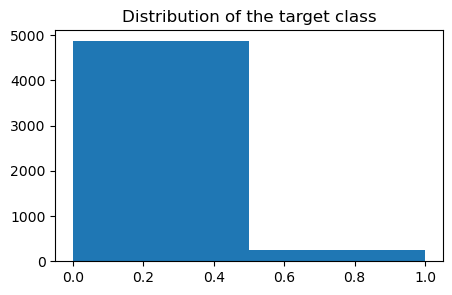

In [8]:
print('Distribution of the target class:')
print('-------------------------------------')
print(df['stroke'].value_counts())

print('\n\nUnique data in the target class:', df['stroke'].nunique(), '\n')

fig = plt.figure(figsize=(5, 3))
plt.hist(df['stroke'], bins = 2)
plt.title('Distribution of the target class')
plt.show()

## Visual representation of the Dataset

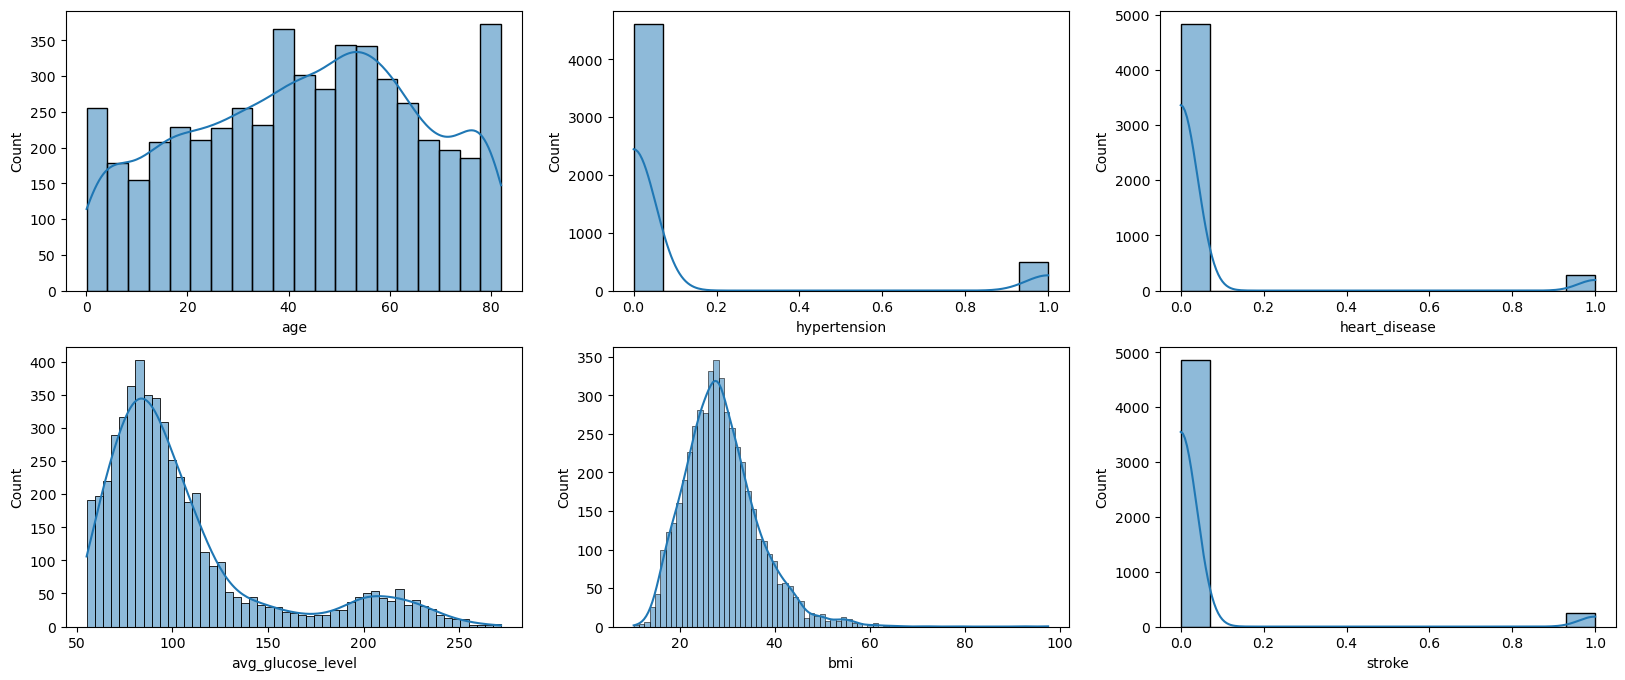

In [9]:
numerical_columns = df.select_dtypes('number').columns

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,8))
axs = axs.ravel()

for i, c in enumerate(numerical_columns):
    sns.histplot(df, x=df[c], ax=axs[i], kde=True)

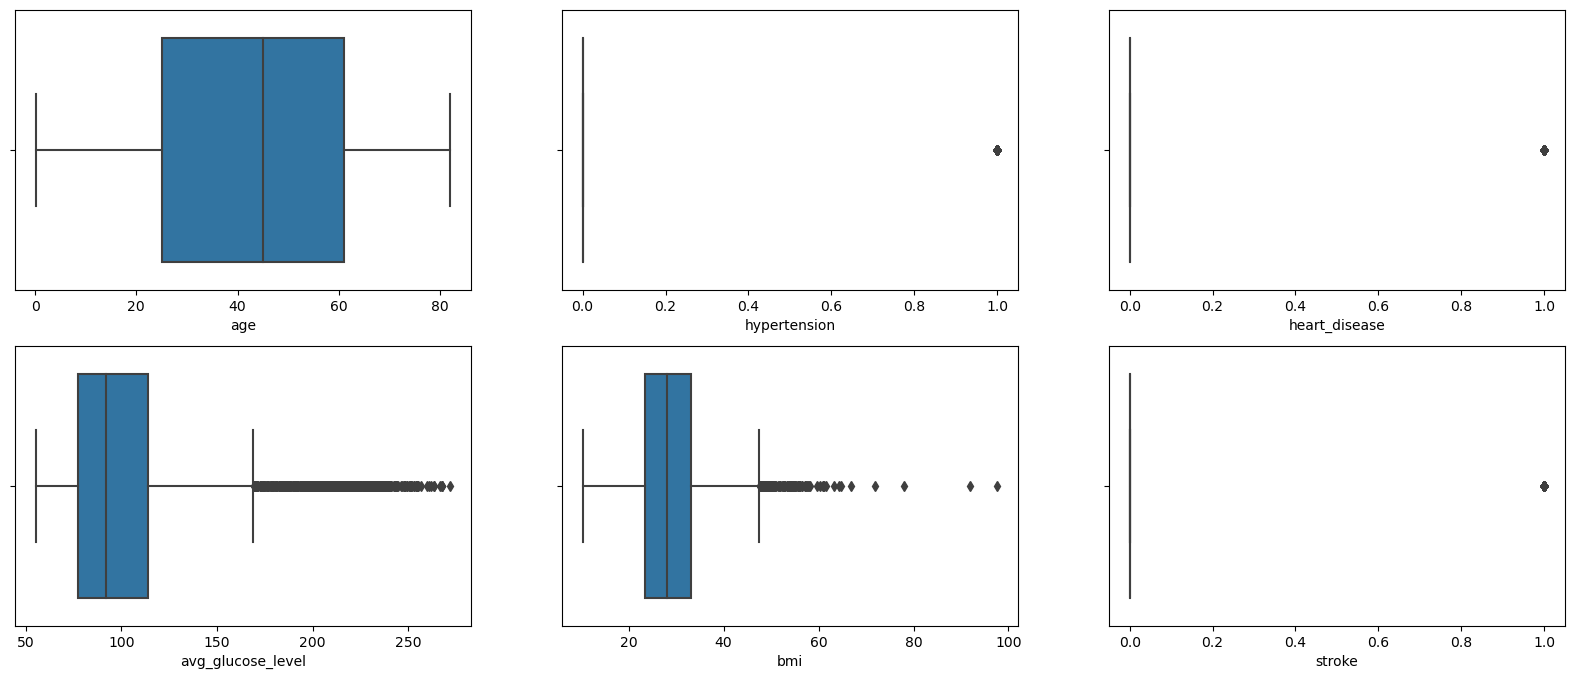

In [10]:
numerical_columns = df.select_dtypes('number').columns

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,8))
axs = axs.ravel()

for i, c in enumerate(numerical_columns):
    sns.boxplot(df, x=df[c], orient='h', ax=axs[i])

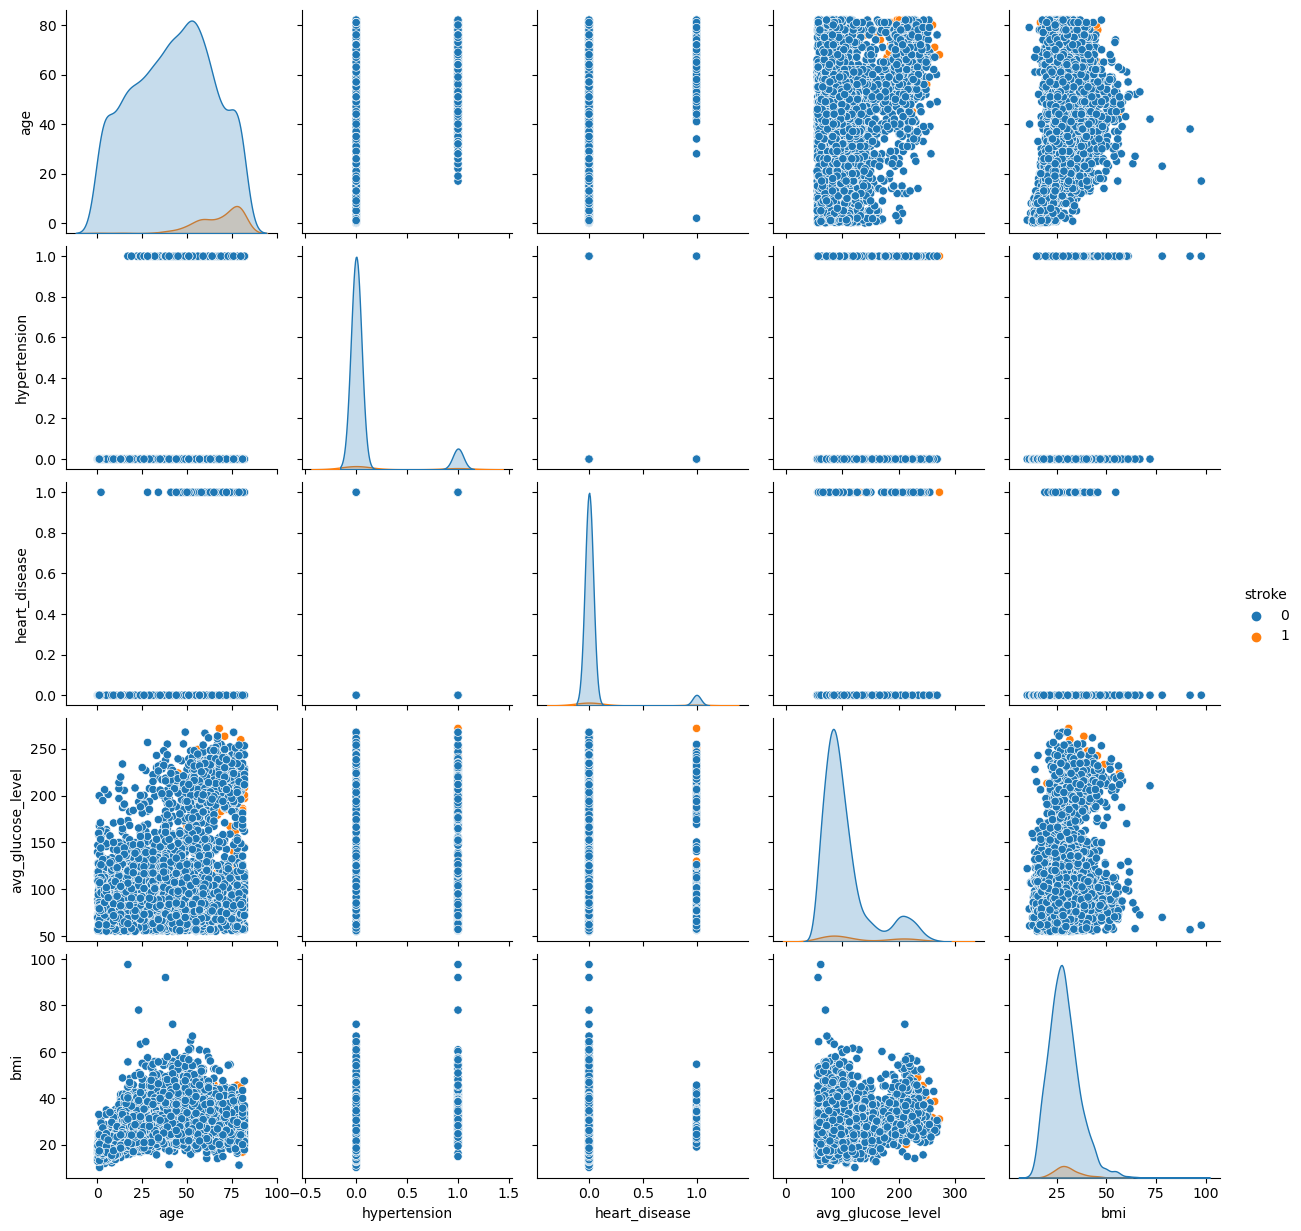

In [11]:
sns.pairplot(df, hue='stroke')
plt.show()

---
## Encoding Categorical features

In [12]:
cat_cols = list(df.select_dtypes('object').columns)

for c in cat_cols:
    df[c] = LabelEncoder().fit_transform(df[c].values)

---
## Imputing NaN values with Linear Regression

In [13]:
TARGET_COL='stroke'

In [14]:
df_copy = df.copy()

# Removing 'stroke' column, because this is future target
df_copy = df_copy.drop([TARGET_COL], axis=1)

# Spliting the data into two sets: one with NaN 'bmi' values and one without NaN 'bmi' values
train_data = df_copy[df_copy['bmi'].notnull()]
test_data = df_copy[df_copy['bmi'].isnull()]

x_train = train_data.drop(['bmi'], axis=1)  
y_train = train_data['bmi']
x_test = test_data.drop(['bmi'], axis=1)

model = LinearRegression()
model.fit(x_train, y_train)

predicted_bmi = model.predict(x_test)

# Filling NaN values in 'bmi' column with the predicted values
df_copy.loc[df_copy['bmi'].isnull(), 'bmi'] = predicted_bmi

# Add 'stroke' column back to the DataFrame
df['bmi'] = df_copy['bmi']

In [15]:
print('Sum of NaN values in each column:\n-------------------------------------------------------------')
print(df.isna().sum(), '\n\n')

Sum of NaN values in each column:
-------------------------------------------------------------
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64 




## Correlation between columns

<Axes: >

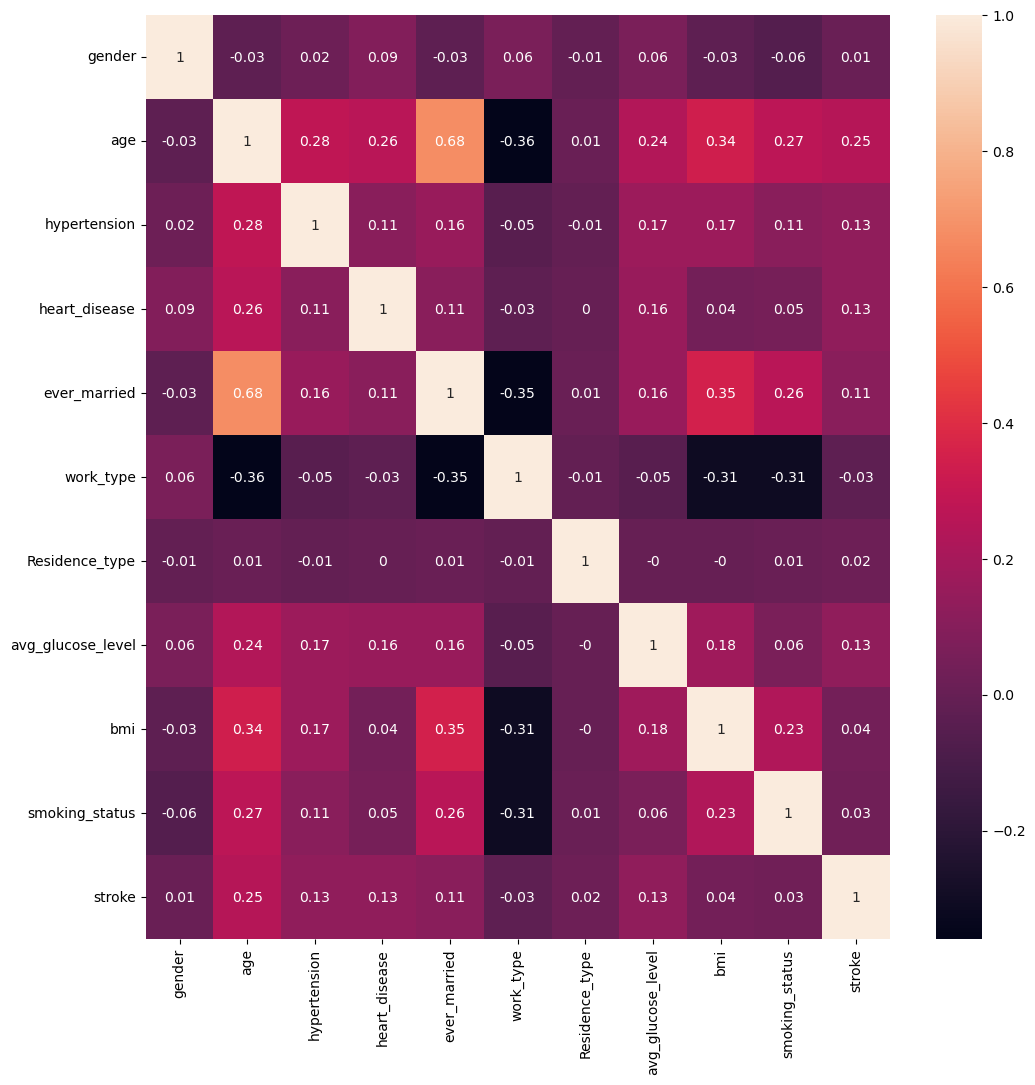

In [16]:
df_corr = df.corr(numeric_only=True, method='pearson').round(decimals=2)
plt.figure(figsize=(12,12))
sns.heatmap(df_corr, annot=True) 

---
# CONCLUSION from EDA:
## 

## Target Class - Univariate analysis
Target class is the 'stroke' column. It has two values 0 and 1, therefore this is BINARY CLASSIFICATION problem.
The class is highly unbalanced, so few methods and techiques will be applied to address this issue as well as using stratification when splitting the data.

## Key findings from Heatmap:
Heatmap shows high positive correlation between the following features: 'ever_married' and 'age'.
At this point I decided to leave them in the dataset.   

## Key findings from Histplots:  
Some of the features have similar to normal distribution and some are highly unbalanced. At this point I decided not to transform the features, but later on in some of the experiments I'm applying SMOTE oversampling method for for balancing data.

## Key findings from Boxplots:
Box plots shows few outliers in some of the features. At this point I decided to leave them in the dataset.

## Key findings from Pairplot:
2D Pairwise relationships between variables in a dataset shows that a positive target class (the minority class) is associated with higher values in the features: 'age', 'average glucose level', 'bmi', 'hypertension' and 'hearth disease'. 

---

#
#

---
# Feed Forward Neural Network - Binary classification model

## Train – Validation – Test  stratified splits and scaling

In [17]:
X = df.drop(columns=[TARGET_COL])
Y = df[TARGET_COL]

In [18]:
def split_and_scale(df: pd.DataFrame):
    
    X_train, X_vt, Y_train, Y_vt = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=SEED, stratify = Y)
    
    assert X_train.shape[0] == Y_train.shape[0]
    assert X_vt.shape[0]    == Y_vt.shape[0]
    assert X_train.shape[1] == X_vt.shape[1]

    
    X_val, X_test, Y_val, Y_test = train_test_split(X_vt, Y_vt, test_size=0.5, shuffle=True, random_state=SEED, stratify = Y_vt)
    
    assert X_val.shape[0]   == Y_val.shape[0]
    assert X_test.shape[0]  == Y_test.shape[0]
    assert X_val.shape[1]   == X_test.shape[1]
    
    
    X_train = MinMaxScaler().fit_transform(X_train)
    X_val   = MinMaxScaler().fit_transform(X_val)
    X_test  = MinMaxScaler().fit_transform(X_test)

    return X_train, Y_train.to_numpy(), X_val, Y_val.to_numpy(), X_test, Y_test.to_numpy()

## Model definition and optimization process

In [19]:
def make_and_compile_model(hyper_params: dict, show_summary: bool = False) -> Sequential:
    
    model = Sequential()
    
    # INPUT LAYER
    model.add(Input(hyper_params['input_size']))                         

    # HIDDEN LAYERS
    for hu, ac, dp, bn, kr in zip(  hyper_params['h_layers'],
                                    hyper_params['activations'],
                                    hyper_params['dropout_size'],
                                    hyper_params['batch_normalization'],
                                    hyper_params['kernel_regularizers'],
                                    ):
        if kr is None:
            model.add(Dense(hu, activation=ac))
        else:
            model.add(Dense(hu, activation=ac, kernel_regularizer=kr))
        if bn:
            model.add(BatchNormalization())
        if dp > 0.0:
            model.add(Dropout(dp))

    # OUTPUT LAYER
    model.add(Dense(hyper_params['output_size'], activation=hyper_params['output_activation']))

    if show_summary:
        model.summary()

    model.compile(loss=hyper_params['loss'], optimizer=hyper_params['optimizer'], metrics=hyper_params['metrics'])

    return model

## Training the model

In [20]:
def train_model(model, model_name, X_train, Y_train, X_val, Y_val, quiet=False):
    
    es_cbk = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    #chp_cbk = ModelCheckpoint(monitor='val_loss', filepath=os.path.join('models', model_name), save_best_only=True)

    model_history = model.fit(X_train,
                            Y_train,
                            epochs=1000,
                            batch_size = 128, # 16, 32, 64, 128, 256,
                            validation_data = (X_val, Y_val),
                            callbacks = [es_cbk],  #, chp_cbk],
                            shuffle=True,
                            verbose=0 if quiet else 1
                            )
    return model_history

In [21]:
def learning_curve(model_history, model_name):
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.plot(title=f'Loss learning curve ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train','Val'])
    plt.show()

## Model prediction and model evaluation


In [22]:
def test_eval_model(model, model_name, X_test, Y_test) -> dict:
    
    Y_pred_probability = model.predict(X_test, verbose=0) 
    
    Threshold = 0.5   # OPTION 1
#   Threshold = 0.4   # OPTION 2
#   Threshold = 0.3   # OPTION 3
#   Threshold = 0.2   # OPTION 4  

    Y_pred = (Y_pred_probability >= Threshold).astype(int)    
    
    eval_dict = {
      'Model name:': model_name,
      'F1 score (macro)  (%):': round((f1_score(Y_test, Y_pred, average='macro'))*100, 3),
      'F1 score (binary) (%):': round((f1_score(Y_test, Y_pred, average='binary'))*100, 3),
      'Accuracy          (%):': round((accuracy_score(Y_test, Y_pred))*100, 3),
      'Precision score   (%):': round((precision_score(Y_test, Y_pred))*100, 3),
      'Recall score      (%):': round((recall_score(Y_test, Y_pred))*100, 3),
      'Confusion Matrix     :': confusion_matrix(Y_test, Y_pred)
      }
       
    display(pd.DataFrame.from_dict(eval_dict, orient='index'))

    ClassificationReport = pd.DataFrame(classification_report(Y_test, Y_pred, output_dict=True)).transpose()
    ClassificationReport.index.name = 'Classification Report'
    display(ClassificationReport)
    
    return eval_dict   

In [23]:
def model_loop(hyper_params: dict, df: pd.DataFrame, model_name: str):
    print("1. Getting and splitting data...", end=' ')
    X_train, Y_train, X_val, Y_val, X_test, Y_test = split_and_scale(df)
    print("Done!")
    
    print("2. Creating and compiling model...", end=' ')
    model = make_and_compile_model(hyper_params, show_summary=False)
    print("Done!")

    print("3. Training model...", end=' ')
    model_history = train_model(model, model_name, X_train, Y_train, X_val, Y_val, quiet=True)
    print("Done!")

    print("4. Validating and evaluating model...", end=' ')
    learning_curve(model_history, model_name)
    metrics_dict = test_eval_model(model, model_name, X_test, Y_test)
    print("Done!")
    print("---------------------------------------------------------------------------------------\n\n")
    return metrics_dict


Model name:  Baseline_model
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

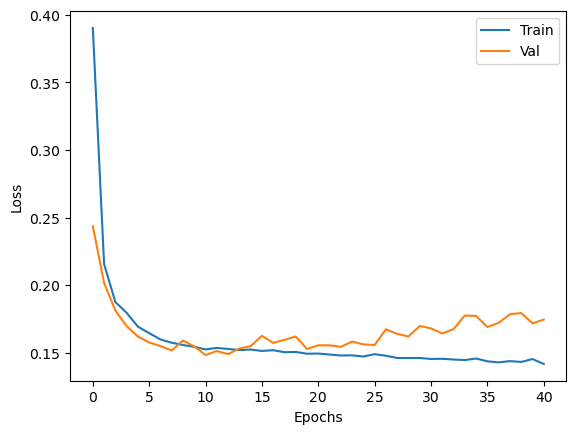

,0
Model name:,Baseline_model
F1 score (macro) (%):,48.746
F1 score (binary) (%):,0.0
Accuracy (%):,95.108
Precision score (%):,0.0
Recall score (%):,0.0
Confusion Matrix :,"[[486, 0], [25, 0]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.951076,1.000000,0.974925,486.000000
1,0.000000,0.000000,0.000000,25.000000
accuracy,0.951076,0.951076,0.951076,0.951076
macro avg,0.475538,0.500000,0.487462,511.000000
weighted avg,0.904546,0.951076,0.927228,511.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp1_5Layers
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

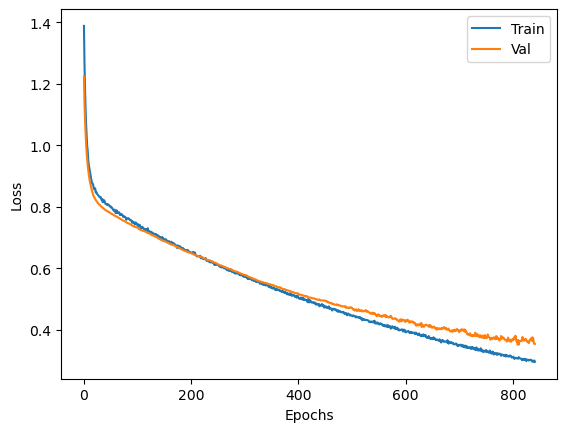

,0
Model name:,Exp1_5Layers
F1 score (macro) (%):,55.356
F1 score (binary) (%):,13.333
Accuracy (%):,94.912
Precision score (%):,40.0
Recall score (%):,8.0
Confusion Matrix :,"[[483, 3], [23, 2]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.954545,0.993827,0.973790,486.000000
1,0.400000,0.080000,0.133333,25.000000
accuracy,0.949119,0.949119,0.949119,0.949119
macro avg,0.677273,0.536914,0.553562,511.000000
weighted avg,0.927415,0.949119,0.932672,511.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp2_5Layers
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

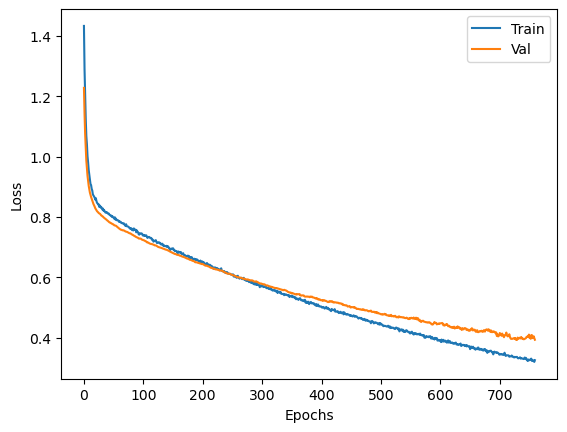

,0
Model name:,Exp2_5Layers
F1 score (macro) (%):,51.922
F1 score (binary) (%):,6.667
Accuracy (%):,94.521
Precision score (%):,20.0
Recall score (%):,4.0
Confusion Matrix :,"[[482, 4], [24, 1]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.952569,0.991770,0.971774,486.000000
1,0.200000,0.040000,0.066667,25.000000
accuracy,0.945205,0.945205,0.945205,0.945205
macro avg,0.576285,0.515885,0.519220,511.000000
weighted avg,0.915751,0.945205,0.927493,511.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp3_6Layers
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

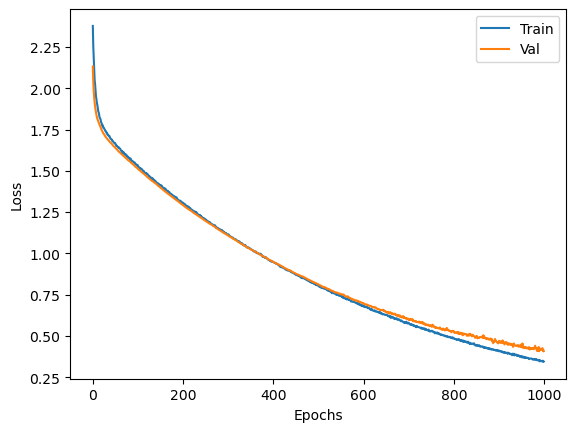

,0
Model name:,Exp3_6Layers
F1 score (macro) (%):,57.726
F1 score (binary) (%):,18.182
Accuracy (%):,94.716
Precision score (%):,37.5
Recall score (%):,12.0
Confusion Matrix :,"[[481, 5], [22, 3]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.956262,0.989712,0.972700,486.000000
1,0.375000,0.120000,0.181818,25.000000
accuracy,0.947162,0.947162,0.947162,0.947162
macro avg,0.665631,0.554856,0.577259,511.000000
weighted avg,0.927825,0.947162,0.934007,511.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp4_6Layers
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

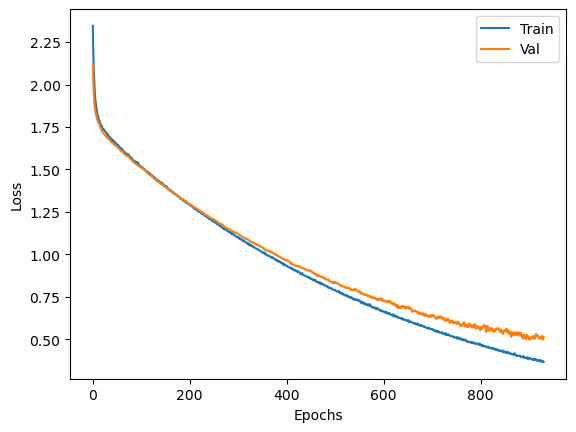

,0
Model name:,Exp4_6Layers
F1 score (macro) (%):,57.726
F1 score (binary) (%):,18.182
Accuracy (%):,94.716
Precision score (%):,37.5
Recall score (%):,12.0
Confusion Matrix :,"[[481, 5], [22, 3]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.956262,0.989712,0.972700,486.000000
1,0.375000,0.120000,0.181818,25.000000
accuracy,0.947162,0.947162,0.947162,0.947162
macro avg,0.665631,0.554856,0.577259,511.000000
weighted avg,0.927825,0.947162,0.934007,511.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp5_NO_bn
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

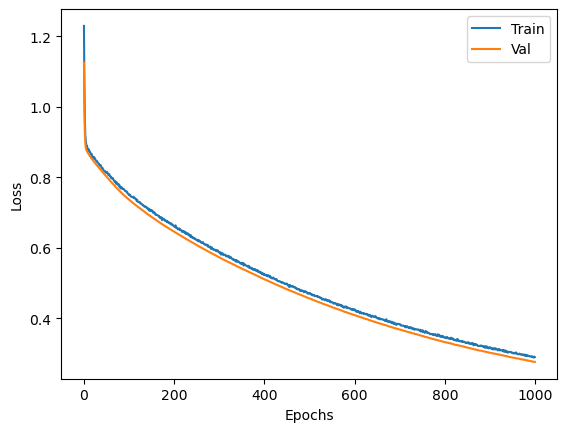

,0
Model name:,Exp5_NO_bn
F1 score (macro) (%):,48.746
F1 score (binary) (%):,0.0
Accuracy (%):,95.108
Precision score (%):,0.0
Recall score (%):,0.0
Confusion Matrix :,"[[486, 0], [25, 0]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.951076,1.000000,0.974925,486.000000
1,0.000000,0.000000,0.000000,25.000000
accuracy,0.951076,0.951076,0.951076,0.951076
macro avg,0.475538,0.500000,0.487462,511.000000
weighted avg,0.904546,0.951076,0.927228,511.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp6_NO_dp
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

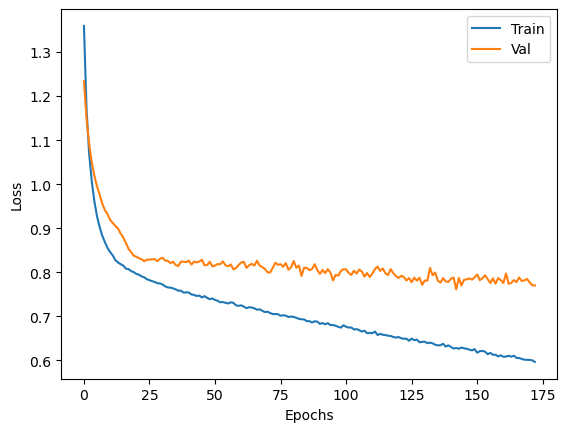

,0
Model name:,Exp6_NO_dp
F1 score (macro) (%):,56.014
F1 score (binary) (%):,15.385
Accuracy (%):,93.542
Precision score (%):,21.429
Recall score (%):,12.0
Confusion Matrix :,"[[475, 11], [22, 3]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.955734,0.977366,0.966429,486.000000
1,0.214286,0.120000,0.153846,25.000000
accuracy,0.935421,0.935421,0.935421,0.935421
macro avg,0.585010,0.548683,0.560138,511.000000
weighted avg,0.919460,0.935421,0.926675,511.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp7_NO_kr
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

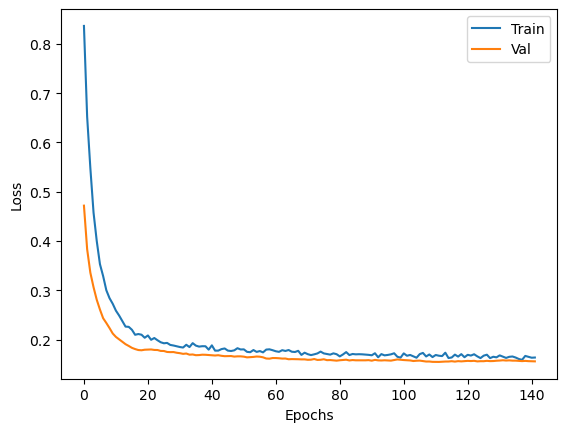

,0
Model name:,Exp7_NO_kr
F1 score (macro) (%):,48.746
F1 score (binary) (%):,0.0
Accuracy (%):,95.108
Precision score (%):,0.0
Recall score (%):,0.0
Confusion Matrix :,"[[486, 0], [25, 0]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.951076,1.000000,0.974925,486.000000
1,0.000000,0.000000,0.000000,25.000000
accuracy,0.951076,0.951076,0.951076,0.951076
macro avg,0.475538,0.500000,0.487462,511.000000
weighted avg,0.904546,0.951076,0.927228,511.000000


Done!
---------------------------------------------------------------------------------------




In [24]:
grid_dict = {
    'Baseline_model': {
        'input_size': X.shape[1],

        'h_layers': [256, 64, 16],
        'activations': ['relu', 'relu', 'relu'],
        'dropout_size': [0, 0, 0],
        'batch_normalization': [False, False, False],
        'kernel_regularizers': [None, None] * 3,  
        
        'output_size': 1,
        'output_activation': 'sigmoid', 


        'optimizer': 'adam',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },
    
        
     'Exp1_5Layers': {
        'input_size': X.shape[1],
        
        'h_layers': [256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.15, 0.2, 0.15, 0.2, 0.15],
        'batch_normalization': [True, True, True, True, True],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 5,    
        
        'output_size': 1,
        'output_activation': 'sigmoid', 

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    }, 
        
        
     'Exp2_5Layers': {
        'input_size': X.shape[1],
        
        'h_layers': [256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.15, 0.2, 0.15, 0.2, 0.15],
        'batch_normalization': [True, True, True, True, True],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 5,    
        
        'output_size': 1,
        'output_activation': 'sigmoid', 

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },
    
        
     'Exp3_6Layers': {
        'input_size': X.shape[1],
        
        'h_layers': [512, 256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.25, 0.2, 0.3, 0.25, 0.2, 0.3],
        'batch_normalization': [True, True, True, True, True, True],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 6,  
        
        'output_size': 1,
        'output_activation': 'sigmoid', 

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },
    
        
     'Exp4_6Layers': {
        'input_size': X.shape[1],
        
        'h_layers': [512, 256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.15, 0.2, 0.1, 0.15, 0.2, 0.1],
        'batch_normalization': [True, True, True, True, True, True],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 6,  
        
        'output_size': 1,
        'output_activation': 'sigmoid', 

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },
     
    
     'Exp5_NO_bn': {
        'input_size': X.shape[1],
        
        'h_layers': [256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.15, 0.2, 0.15, 0.2, 0.15],
        'batch_normalization': [False, False, False, False, False],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 5,  
        
        'output_size': 1,
        'output_activation': 'sigmoid', 

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    }, 
    
    
    'Exp6_NO_dp': {
        'input_size': X.shape[1],
        
        'h_layers': [256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0, 0, 0, 0, 0],
        'batch_normalization': [True, True, True, True, True],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 5,  
        
        'output_size': 1,
        'output_activation': 'sigmoid', 

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    }, 
 
    
    'Exp7_NO_kr':  {
        'input_size': X.shape[1],
        
        'h_layers': [256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.15, 0.20, 0.15, 0.20, 0.15],
        'batch_normalization': [True, True, True, True, True],
        'kernel_regularizers': [None, None] * 5,
         
        'output_size': 1,
        'output_activation': 'sigmoid', 

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    }
}

eval_results = []
for model_name, hyper_d in grid_dict.items():
    print('\nModel name: ', model_name)
    print('----------------------------------------')
    eval_results.append(model_loop(hyper_d, df, model_name))

# RESULTS

In [25]:
pd.DataFrame(eval_results)

,Model name:,F1 score (macro) (%):,F1 score (binary) (%):,Accuracy (%):,Precision score (%):,Recall score (%):,Confusion Matrix :
0,Baseline_model,48.746,0.000,95.108,0.000,0.0,"[[486, 0], [25, 0]]"
1,Exp1_5Layers,55.356,13.333,94.912,40.000,8.0,"[[483, 3], [23, 2]]"
2,Exp2_5Layers,51.922,6.667,94.521,20.000,4.0,"[[482, 4], [24, 1]]"
3,Exp3_6Layers,57.726,18.182,94.716,37.500,12.0,"[[481, 5], [22, 3]]"
4,Exp4_6Layers,57.726,18.182,94.716,37.500,12.0,"[[481, 5], [22, 3]]"
5,Exp5_NO_bn,48.746,0.000,95.108,0.000,0.0,"[[486, 0], [25, 0]]"
6,Exp6_NO_dp,56.014,15.385,93.542,21.429,12.0,"[[475, 11], [22, 3]]"
7,Exp7_NO_kr,48.746,0.000,95.108,0.000,0.0,"[[486, 0], [25, 0]]"


#### CONCLUSION:     
Overall, our model faces challenges with its performance due to the significant class imbalance. This disproportionately impacts the accuracy of predictions for the underrepresented class. Therefore few other experiments were done in order to maximize the performance.

---

#

## Experimentation with different threshold  
---

#### CONSLUSION:
A slight improvement is observed when reducing the threshold. However, it is important to note that this improvement comes at the cost of a slight increase in both False Negatives and False Positives within our Confusion Matrix.


### 1) Threshold = 0.4    
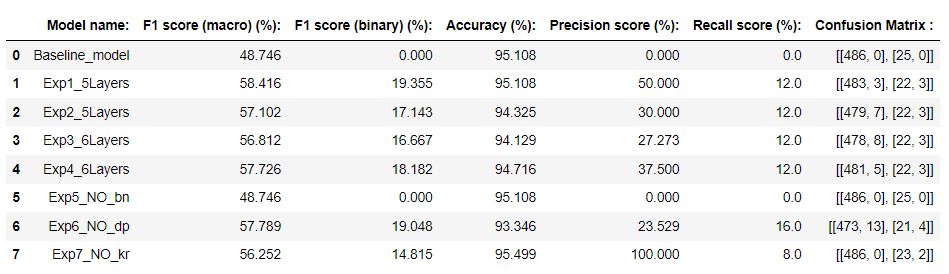


### 2) Threshold = 0.3    
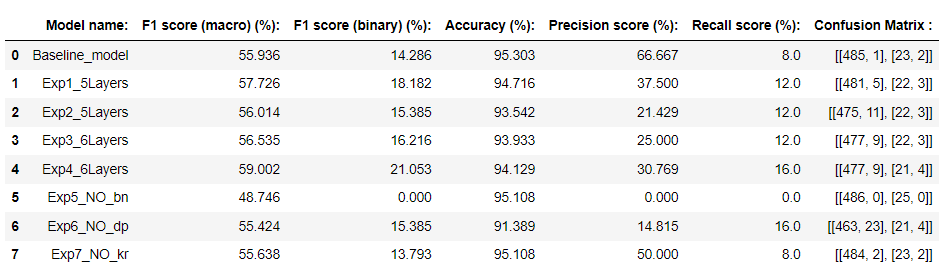


### 3) Threshold = 0.2    
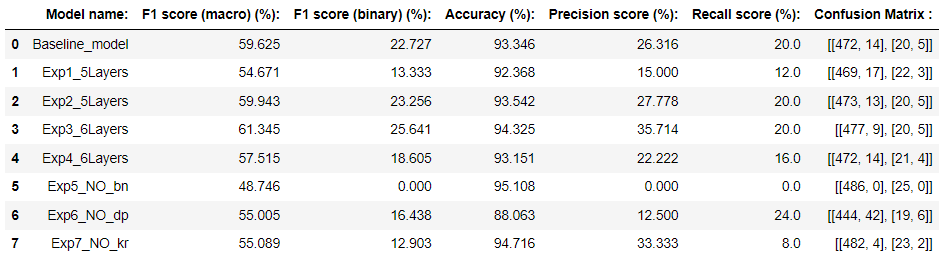


Additional experimentation is done by applying SMOTE oversampling technique for balancing data.